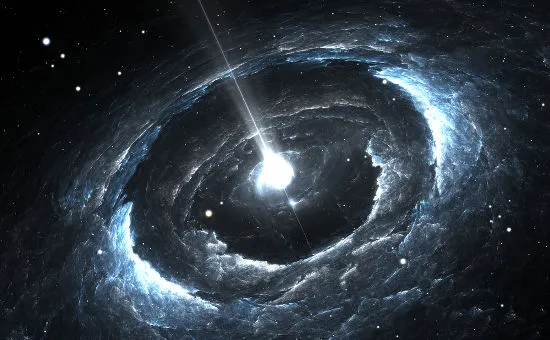

# Características do dataset e pré-processamento

---

# Características e descrição do problema

### Descrição do problema

Pulsares são estrelas de nêutrons que giram rapidamente e emitem feixes de ondas de rádio. \
Detectar essas estrelas é uma tarefa relevante para várias aplicações da astronomia, como:
- Cronometragem de alta precisão
- Detecção de planetas extrasolares
- Mecânica celeste e astrometria
- Estudos de matéria superdensa
- Física gravitacional no regime de campo forte 
- Física de plasma sob condições extremas

Outras aplicações podem ainda ser encontradas em algumas referências como:
```citation
LORIMER, D. R., & KRAMER, M. (2005). Handbook of pulsar astronomy. Cambridge, UK, Cambridge University Press.
```

### Variáveis
O dataset é composto por 8 variáveis independentes e 1 variável alvo que é a classificação do pulsar.

#### Variáveis independentes
As variáveis independentes são todas quantitativas contínuas, mas variam as suas classificações entre variáveis intervalares e racionais:
- média do perfil integrado: **racional** (zero absoluto = 0, significa ausência de sinal de rádio, unidade de medida é W/m²)
- desvio padrão do perfil integrado: **intervalar**
- curtose do perfil integrado: **intervalar**
- assimetria do perfil integrado: **intervalar**
- media da curva dm-snr: **racional** (zero absoluto = 0, significa ausência de sinal de rádio)
- desvio padrão da curva dm-snr: **intervalar**
- curtose da curva dm-snr: **intervalar**
- assimetria da curva dm-snr: **intervalar**

#### Variável dependente
As classes são dividídas em 2:
- 1: classificado como **pulsar**
- 0: classificado como **ruído**

### Instâncias e balanceamento das classes

- Número total de instâncias: 17.898
- Classe 0 (rúido): 16.259 (90,84%)
- Classe 1 (pulsar): 1.639 (9,16%)

### Instâncias sem missing values
- 17.898, não há missing values no dataset.


### Glossário
- **Phase**: Período ou fase de rotação do pulsar
- **Perfil Integrado**: Vetor de intensidade do sinal de rádio nos diferentes períodos de rotação do pulsar (W/m²)
- **DM-SNR**: Vetor da razão de sinal-ruído para diferentes valores de medidas de dispersão
- **SNR**: Razão de intensidade de sinal para ruído (Signal to Noise Ratio)
- **DM**: Medida de dispersão (Dispersion Measure)

---

# Bibliotecas

In [1]:
from itertools import product

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

# Dataset

In [2]:
DATASET_PATH: str = "../data/raw/HTRU_2.csv"

In [3]:
df = pd.read_csv(DATASET_PATH)

---

## Shape

In [4]:
print("Instâncias totais:", df.shape[0])

Instâncias totais: 17898


In [5]:
print("Distribuição das classes")
(
    df.groupby("pulsar")
    .agg({"pulsar": "count"})
    .rename(columns={"pulsar": "abs_freq"})
    .assign(rel_freq=lambda df: df.abs_freq/df.abs_freq.sum())
    .style
    .bar(subset=["rel_freq"])
    .format("{:.2%}", subset=["rel_freq"])
)

Distribuição das classes


,abs_freq,rel_freq
pulsar,,
0,16259,90.84%
1,1639,9.16%


## Missing

In [6]:
df.isna().sum()

perfil_integrado_media         0
perfil_integrado_desvio        0
perfil_integrado_curtose       0
perfil_integrado_assimetria    0
dmsnr_media                    0
dmsnr_desvio                   0
dmsnr_curtose                  0
dmsnr_assimetria               0
pulsar                         0
dtype: int64

Nenhuma feature com valores nulos.

---

# Análise exploratória de dados

Distribuição das características entre as duas classes

In [7]:
features = df.columns.tolist()[:-1]

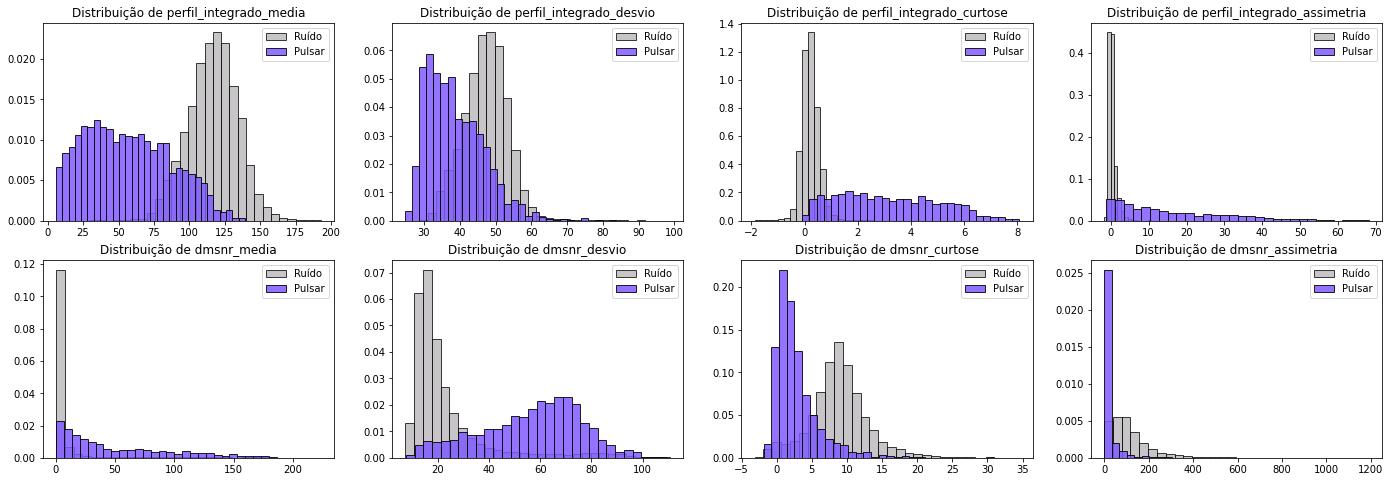

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes_indexes = list(product(list(range(0, 2)), list(range(0, 4))))

for idx, feature in enumerate(features):
    index = axes_indexes[idx]
    ax = axes[index[0], index[1]]
    ax.hist(df[df.pulsar==0][feature], bins=30, color='#B6B2B8', edgecolor='k', alpha=0.75, label="Ruído", density=1)
    ax.hist(df[df.pulsar==1][feature], bins=30, color='#805BFF', edgecolor='k', alpha=0.85, label="Pulsar", density=1)
    ax.set_title(f"Distribuição de {feature}")
    ax.legend()

plt.show()

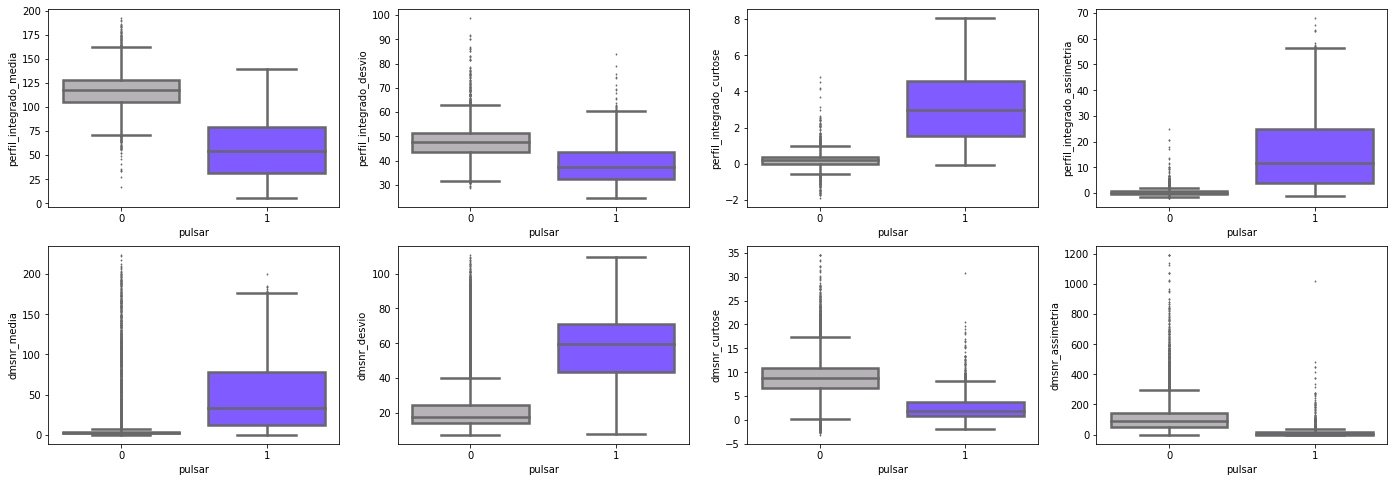

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes_indexes = list(product(list(range(0, 2)), list(range(0, 4))))
colors = ["#B6B2B8", "#805BFF"]
palette = sns.set_palette(sns.color_palette(colors))

for idx, feature in enumerate(features):
    index = axes_indexes[idx]
    ax = axes[index[0], index[1]]
    sns.boxplot(data=df, x="pulsar", y=feature, ax=ax, palette=palette, fliersize=1, saturation=1, linewidth=2.5)

plt.show()

## Teste de correlação

<AxesSubplot:>

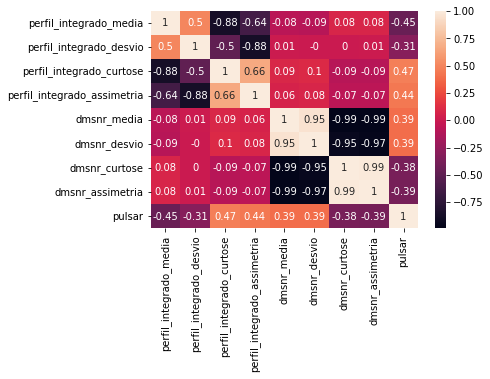

In [14]:
sns.heatmap(df.corr("spearman").round(2), annot=True)

## Teste de normalidade das features

In [11]:
from scipy.stats import normaltest

A hipótese nula é a de que a variável tem uma distribuição normal, \
rejeitar a hipótese nula significa assumir que as variáveis não possuem uma \
distribuição normal.

In [12]:
test_results = list()

for feature in features:
    pvalue = normaltest(df[feature]).pvalue
    test_results.append((feature, pvalue))

normality_test_df = (
    pd.DataFrame(test_results, columns=["feature", "pvalue"])
    .assign(is_normal=lambda df: df.pvalue > 5e-2)
)

In [13]:
normality_test_df

,feature,pvalue,is_normal
0,perfil_integrado_media,0.000000e+00,False
1,perfil_integrado_desvio,2.393003e-159,False
2,perfil_integrado_curtose,0.000000e+00,False
3,perfil_integrado_assimetria,0.000000e+00,False
4,dmsnr_media,0.000000e+00,False
5,dmsnr_desvio,0.000000e+00,False
6,dmsnr_curtose,1.476206e-247,False
7,dmsnr_assimetria,0.000000e+00,False


---

# Etapas de pré-processamento
- Eliminação de ruídos
- Normalização
- Balanceamento de classes